# Analyzing the Nodes dataset

In [10]:
import boto3
import sagemaker
import os
import io
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import OrderedDict
import string
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem

client = boto3.client('s3')
path = 's3://project-sagemaker-3/Data_files/amazon0302_copy.csv'

### Connecting Sagemaker to the S3 bucket

### Importing the Nodes Dataset

In [3]:
lines = []
lines = pd.read_csv(path, sep="\t")
lines['Start\tEnd'][4]

df_nodes = pd.DataFrame(lines)
print(df_nodes)
df_nodes['Start\tEnd'][1]

             Start\tEnd
0                  0\t1
1                  0\t2
2                  0\t3
3                  0\t4
4                  0\t5
...                 ...
1234872  262110\t262099
1234873  262110\t262100
1234874  262110\t262101
1234875  262110\t262106
1234876  262110\t262107

[1234877 rows x 1 columns]


'0\t2'

In [4]:
start, end  =[],[]
edges = []
for l in lines['Start\tEnd']:


  first,second = l.split("\t")

  # Storing Nodes in Start and End for Visualization
  # Storing Nodes in Edges to answer queries

  if(int(first) < 1001 and int(second) < 1001):
    
      start.append(first)
      end.append(second)
    
  edge = []
  edge.append(first)
  edge.append(second)

  edges.append(edge)


### Visualizing the Nodes Dataset

In [5]:
class GraphVisualization:
   
    def __init__(self):
          
        self.visual = []
          
    def appendEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
        
    def visualize(self):
            G = nx.Graph()
            G.add_edges_from(self.visual)
            nx.draw_networkx(G)
            plt.title('Visualizing the Nodes Dataset')
            mng = plt.get_current_fig_manager()
            mng.full_screen_toggle()
            plt.show()

###  Graphing the First 1000 Nodes

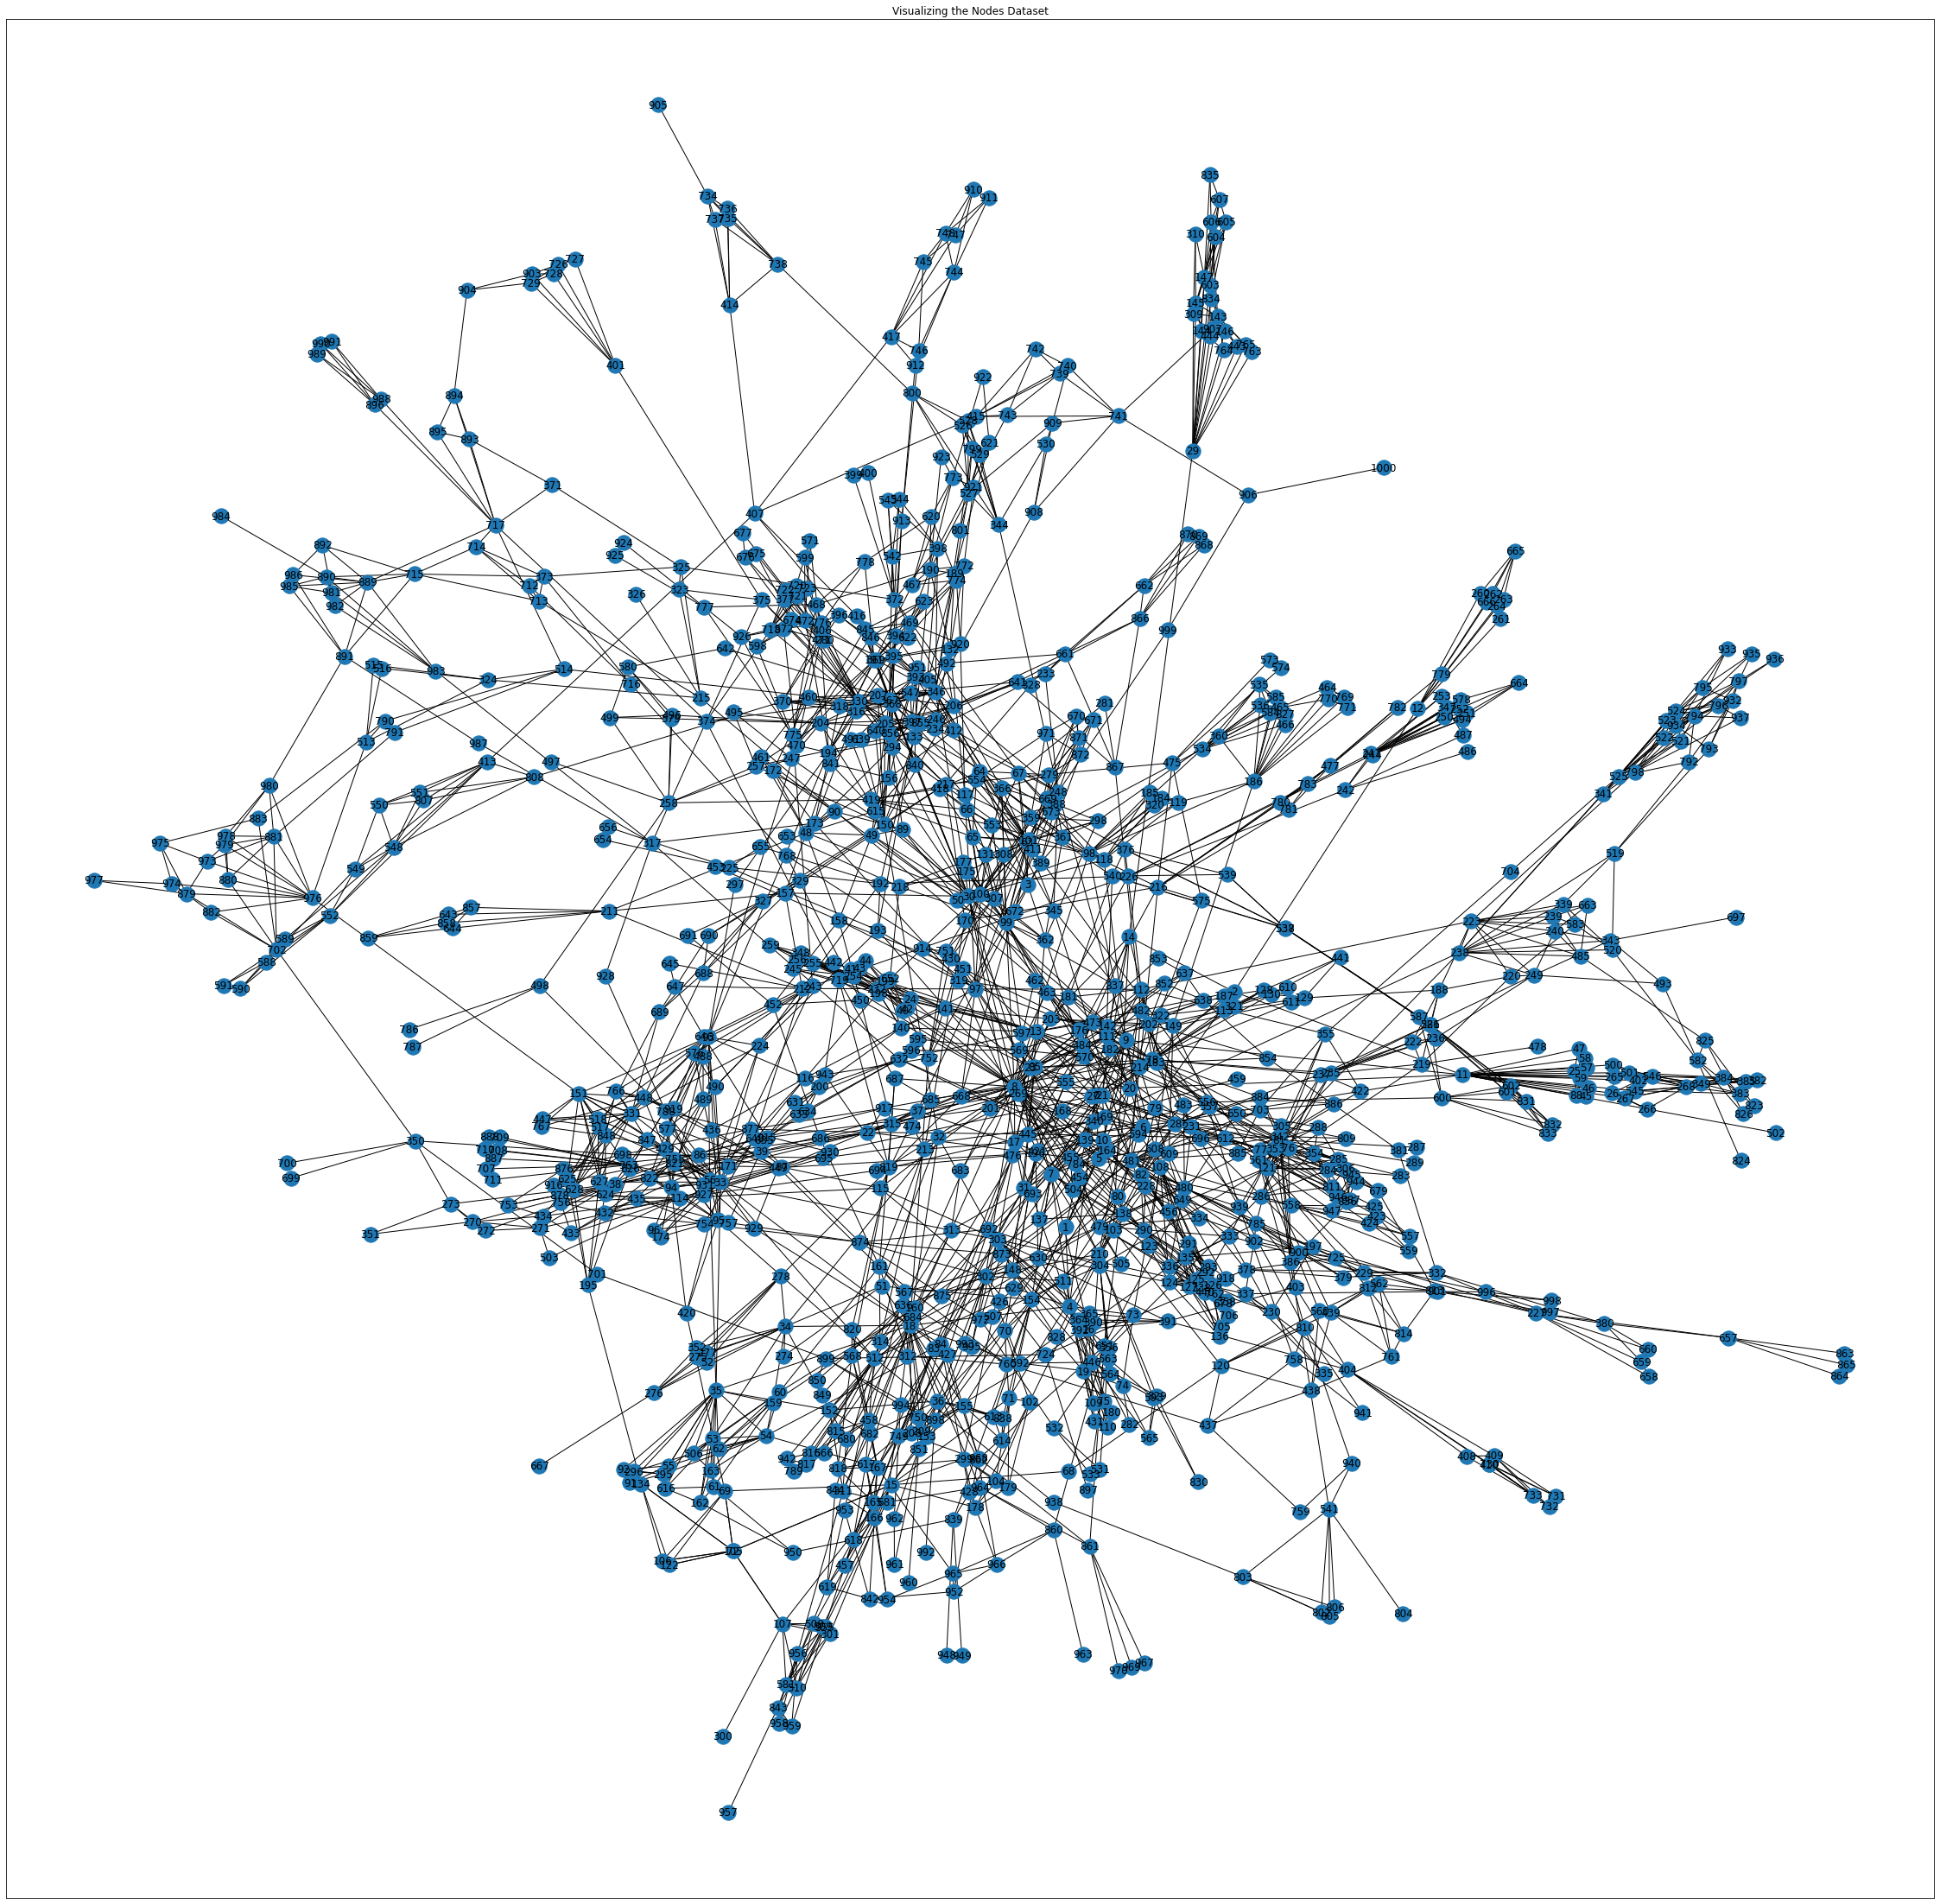

In [6]:
plt.rcParams['figure.figsize'] = [40, 40]
G1 = GraphVisualization()

for i in range(len(start)):

  G1.appendEdge(start[i], end[i])

G1.visualize()

### Importing the Meta Data

In [7]:

fhr = open('new.txt', 'r+', encoding='utf-8', errors='ignore')

# initialize a nested product dictionary that will hold cleaned up amazon product data
# key = ASIN; value = MetaData associated with ASIN
amazonProducts = {}

# read the data from the amazon-meta file and populate amazonProducts nested dicitonary.
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, PeopleRating, Rating_Percent) = \
    ("", "", "", "", "", "", 0, 0, 0.0,"", "")

for line in fhr:
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((fhr.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ', Categories)
        Categories = ' '.join(set(Categories.split()))        
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = int(ls[2].strip())
        AvgRating = float(ls[7].strip())
        #percentage of each rating
        each_rating = [0]*5
        Ratings = []
        per_rating = []
        #helpfulness + low + high rating for each helpful 
        tot_reviews_down = int(ls[4].strip())
        helpful_high = 0
        helpful_low = 0
        high_rating = 0
        low_rating = 0
        stringy = ""
        stringy2 = ""
        for i in range(0, tot_reviews_down):
            liney = fhr.readline()
            liney = liney.strip()
            split_line = liney.split(" ")
            split_line = list(filter(None, split_line))
            #for helpfulness + low + high reviews:
            if tot_reviews_down == 0:
                high_rating = 0
                helpful_high = 0
            elif tot_reviews_down == 1:
                high_rating = int(split_line[4])
                helpful_high = int(split_line[8])
            elif tot_reviews_down == 2 or tot_reviews_down>2:
                if int(split_line[4]) >= AvgRating and int(split_line[8]) > helpful_high:
                    helpful_high = int(split_line[8])
                    high_rating = int(split_line[4])
                if int(split_line[4]) < AvgRating and int(split_line[8]) >= helpful_low:
                    helpful_low = int(split_line[8])
                    low_rating = int(split_line[4])
            stringy = "high_rating=" + str(high_rating)+" high_helpful="+str(helpful_high)
            if low_rating != 0:
                stringy = stringy+ " low_rating=" +str(low_rating)+" low_helpful="+str(helpful_low)
                
            #For getting percentage of ratings in the reviews:
            if int(split_line[4]) == 1:
                each_rating[0] += 1
            elif int(split_line[4]) == 2:
                each_rating[1] += 1
            elif int(split_line[4]) == 3:
                each_rating[2] += 1
            elif int(split_line[4]) == 4:
                each_rating[3] += 1
            elif int(split_line[4]) == 5:
                each_rating[4] += 1
                
        for i in range(0, len(each_rating)):
            if tot_reviews_down != 0:
                percent = (each_rating[i]/tot_reviews_down)*100
                ans = " " + str(i+1) + " occurs " + str(percent) + " percent. "
            stringy2 = stringy2 + ans
            
        per_rating.append(stringy2)    
        Ratings.append(stringy)#for helpfulness + low + high ratings 
    # a product block ended
    # write out fields to amazonProducts Dictionary
    elif (line==""):
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN]=MetaData
            MetaData['Id'] = Id            
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['PeopleRating'] = ' '.join(set(Ratings))
            MetaData['Rating_Percent'] = ''.join(set(per_rating))
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, PeopleRating, Rating_Percent) = \
            ("", "", "", "", "", "", 0, 0, 0.0,"", "")
fhr.close()



## Q6 : If a user is at the amazon.com page for the bestselling product and from then on is only using the links under “Customers who bought this item also bought” list to view other items, how many items (clicks) later will they reach the worst selling product? What was the path taken? List the items in the order in which they were clicked.

Steps taken:
* Identify the Best and Worst Selling Product
* Find the shortest path between the two, using Breadth First Search
* Print the output

### Identify the Best and Worst Selling Product

In [8]:
# Product with Least Sales is the Number 

key_leastsales = max(amazonProducts, key=lambda x: amazonProducts[x]['SalesRank'])
print("Product with Least sales: ",amazonProducts[key_leastsales]['Title'])
print("Product Key: ",key_leastsales)
print(amazonProducts[key_leastsales]['Id'])

# Product with Highest Sales

key_maxsales = min(amazonProducts, key=lambda x: amazonProducts[x]['SalesRank'])
print("Product with Maximum sales: ",amazonProducts[key_maxsales]['Title'])
print("Product Key: ",key_maxsales)
print(amazonProducts[key_maxsales]['Id'])

Product with Least sales:  Favourite Nights and Caught on a Train (Methuen New Theatrescript)
Product Key:  0413501000
4568
Product with Maximum sales:  Labour and Locality: Uneven Development and the Rural Labour Process (Critical Perspectives on Rural Change Series IV)
Product Key:  1853461822
693


### Shortest Path between two nodes using BFS

In [9]:

graph = defaultdict(list)
answer_q3 =[]

def build_graph():

    # Creating a graph as adjacency list
    # Using Edges from Nodes dataset

    for edge in edges:
        a, b = edge[0], edge[1]
         
        # Creating the graph
        # as adjacency list
        graph[a].append(b)
        graph[b].append(a)

    return graph

 
if __name__ == "__main__":
    graph = build_graph()

In [10]:
# Function to find the shortest path between two nodes of a graph

def BFS_SP(graph, start, goal):
    explored = []
     
    # Queue for traversing as BFS
    queue = [[start]]
     
    while queue:
        path = queue.pop(0)
        node = path[-1]
         
        # Condition to check if the current node is not visited
        if node not in explored:
            neighbours = graph[node]
             
            # Loop to iterate over the neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                 
                # Condition to check if the neighbour node is the goal
                if neighbour == goal:
                    print("Shortest path = ", *new_path)
                    return new_path
            explored.append(node)
 
    # Condition when the nodes
    # are not connected
    print("A path doesn't exist between these nodes")
    return
 
 
# Driver Code
if __name__ == "__main__":
     
    # Graph using dictionaries

    # Function Call
    answer_q3 = BFS_SP(graph, amazonProducts[key_maxsales]['Id'], amazonProducts[key_leastsales]['Id'])

Shortest path =  693 340 696 481 77068 3351 7234 4568


### Q6 Answer: Path from Best Selling to Worst Selling is:

In [11]:
# Counter and Index for traversing Shortest Path

counter = len(answer_q3)
i = 0

while(i < counter):
        
    for key in amazonProducts.keys():

        if(amazonProducts[key]['Id'] == answer_q3[i]):

            print(amazonProducts[key]['Id'])
            print(amazonProducts[key]['Title'])
            i = i + 1 
            if(i == 8):
                break

693
Labour and Locality: Uneven Development and the Rural Labour Process (Critical Perspectives on Rural Change Series IV)
340
When I Grow Up I Want To Be Me
696
Effective Literacy Instruction K-8: Implementing Best Practice (5th Edition)
481
A Major Case: A Novel by Pete Deer
77068
Bearing An Hourglass (Incarnations of Immortality, Book 2)
3351
Monologues from George Bernard Shaw (Monologues from the Masters)
7234
The German Army 1914-18 (Men at Arms Series 80)
4568
Favourite Nights and Caught on a Train (Methuen New Theatrescript)


## Q7: For any user specified product A (“Jack and the Beanstalk”) belonging to group G, which products are in its CoPurchase list? And which groups do those products belong to?

In [14]:
selectedVal = ""
highestsales = float('inf')

for key,value in amazonProducts.items():
    
    for dictnames, val in value.items():
        
        if(dictnames == 'Title' and val == 'Jack and the Beanstalk'):
            
            srank = amazonProducts[key]['SalesRank']
            print("User Specified Product: ",val)
            print("Product Group: ", amazonProducts[key]['Group'])
            print("Sales Rank: ", srank )
            print("Product Key: ", key)
            
            if(srank < highestsales):
                highestsales = srank
                selectedVal = key
           

User Specified Product:  Jack and the Beanstalk
Product Group:  Book
Sales Rank:  135980
Product Key:  0688152813
User Specified Product:  Jack and the Beanstalk
Product Group:  Book
Sales Rank:  699142
Product Key:  0899190855


### We observe that there are two Products with the same same. In this case, we choose the Product with the higher sales

### Q7 Answer: Which Products are present in it's CoPurchase list?

In [15]:
coPurchasedlist = amazonProducts[selectedVal]['Copurchased'].split(" ")
l = len(coPurchasedlist)

for i in range(l-1):
    
    pid = coPurchasedlist[i]
    print("Product Name: ", amazonProducts[pid]['Title'])
    print("Group: ",amazonProducts[pid]['Group'])

Product Name:  Hansel and Gretel
Group:  Book
Product Name:  Rumpelstiltskin
Group:  Book
Product Name:  Goldilocks and the Three Bears
Group:  Book
Product Name:  Rapunzel (Caldecott Medal Book)
Group:  Book
